In [65]:
import numpy as np
from math import log, pi
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.neighbors import NearestNeighbors
from sklearn.utils.validation import check_array, check_X_y, check_is_fitted

class RBFKNeighborsClassifier(BaseEstimator, ClassifierMixin):
    """
    k-NN classifier with RBF (isotropic multivariate normal) weighting.

    Parameters
    ----------
    k : int, default=sqrt(n_training_samples)
        Number of neighbors to consider.
    h : float, default=\frac{e^{-1}}{mean(dist_training_samples)^{-2}+mean(dist_training_samples)^{-1/2}}
        Radius (std. deviation) of the isotropic RBF (covariance = h^2 * I).
    """
    def __init__(self, k: int | None = None, h: float | None = None):
        self.k = k
        self.h = h

    def pre_fit(self, X, y):
        X, y = check_X_y(X, y, ensure_min_samples=1, dtype=float)
        return X, y

    def fit(self, X, y):
        X, y = self.pre_fit(X, y)

        n_samples, n_features = X.shape

        # default k: sqrt(n_samples)
        if self.k is None:
            self.k = int(np.floor(np.sqrt(n_samples)))

        # default h: based on average pairwise distance in training set
        if self.h is None:
            # compute average pairwise distance (inefficient for large n_samples)
            dists = np.linalg.norm(X[:, np.newaxis, :] - X[np.newaxis, :, :], axis=2)
            mean_dist = np.sum(dists) / (n_samples * (n_samples - 1))  # exclude self-distances
            self.h = np.exp(-1) / (mean_dist ** -2 + mean_dist ** -0.5)


        if self.h <= 0:
            raise ValueError("h must be > 0 (standard deviation of RBF).")
        
        k_eff = min(max(1, self.k), n_samples)

        # store data
        self.X_ = X.copy()
        self.y_ = np.asarray(y).copy()
        self.n_features_in_ = n_features

        # classes and integer-encoded labels
        self.classes_, inv = np.unique(self.y_, return_inverse=True)
        self._y_encoded = inv  # length n_samples, values in [0, n_classes-1]
        self.n_classes_ = self.classes_.shape[0]

        # nearest-neighbor structure
        self._k_eff = k_eff
        self._nn = NearestNeighbors(n_neighbors=self._k_eff)
        self._nn.fit(self.X_)

        return self

    def _rbf_logpdf_const(self):
        # constant term of isotropic multivariate normal log-pdf

        if self.k is None or self.h is None:
            raise ValueError("k and h must be set (not None) before calling this method.")

        d = self.n_features_in_
        return -0.5 * d * (np.log(2 * pi) + np.log(self.h * self.h))

    def predict_proba(self, X):
        check_is_fitted(self, attributes=['X_', 'y_', '_nn', 'k', 'h'])
        X = check_array(X, dtype=float)
        n_test = X.shape[0]

        if self.k is None or self.h is None:
            raise ValueError("k and h must be set (not None) before calling this method.")

        # get k nearest neighbors (distances returned in Euclidean norm)
        dists, idxs = self._nn.kneighbors(X, n_neighbors=self._k_eff, return_distance=True)
        # dists shape (n_test, k), idxs same shape
        dists_sq = dists ** 2  # squared euclidean distances

        # compute log-weights for each neighbor: logpdf of N(mu=neighbor, cov=h^2 I)
        const = self._rbf_logpdf_const()
        logw = const - 0.5 * (dists_sq / (self.h * self.h))  # shape (n_test, k)

        # numerical stabilization: subtract max per row before exponentiation
        max_logw = np.max(logw, axis=1, keepdims=True)
        stable_w = np.exp(logw - max_logw)  # now safe to exponentiate

        # accumulate weighted votes per class
        probs = np.zeros((n_test, self.n_classes_), dtype=float)
        neighbor_classes = self._y_encoded[idxs]  # shape (n_test, k)

        # vectorized accumulation per sample using bincount (loop over tests)
        for i in range(n_test):
            w = stable_w[i]
            cls_idx = neighbor_classes[i]
            # sum weights for each class among neighbors
            counts = np.bincount(cls_idx, weights=w, minlength=self.n_classes_)
            probs[i, :] = counts

        # normalize to probabilities
        row_sums = probs.sum(axis=1, keepdims=True)
        # if any row sums are zero (unlikely due to stabilization), assign uniform over neighbor classes
        zero_mask = (row_sums.squeeze() == 0)
        if zero_mask.any():
            for i in np.nonzero(zero_mask)[0]:
                present = np.unique(neighbor_classes[i])
                probs[i, :] = 0.0
                probs[i, present] = 1.0 / present.size
            row_sums = probs.sum(axis=1, keepdims=True)

        probs /= row_sums
        return probs

    def predict(self, X):
        probs = self.predict_proba(X)
        idx = np.argmax(probs, axis=1)
        return self.classes_[idx]

    def score(self, X, y):
        from sklearn.metrics import accuracy_score
        y_pred = self.predict(X)
        return accuracy_score(y, y_pred)


In [66]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

data = load_iris()
X_train, X_test, y_train, y_test = train_test_split(data.data, data.target, random_state=0) #type: ignore
clf = RBFKNeighborsClassifier()
clf.fit(X_train, y_train)
print("Accuracy:", clf.score(X_test, y_test))
probs = clf.predict_proba(X_test[:5])
print("Probs for first 5 test samples:\n", probs)


Accuracy: 0.9736842105263158
Probs for first 5 test samples:
 [[0.         0.06962706 0.93037294]
 [0.         1.         0.        ]
 [1.         0.         0.        ]
 [0.         0.         1.        ]
 [1.         0.         0.        ]]


Test accuracy: 0.9273  (k=13, h=0.3469924031835624)


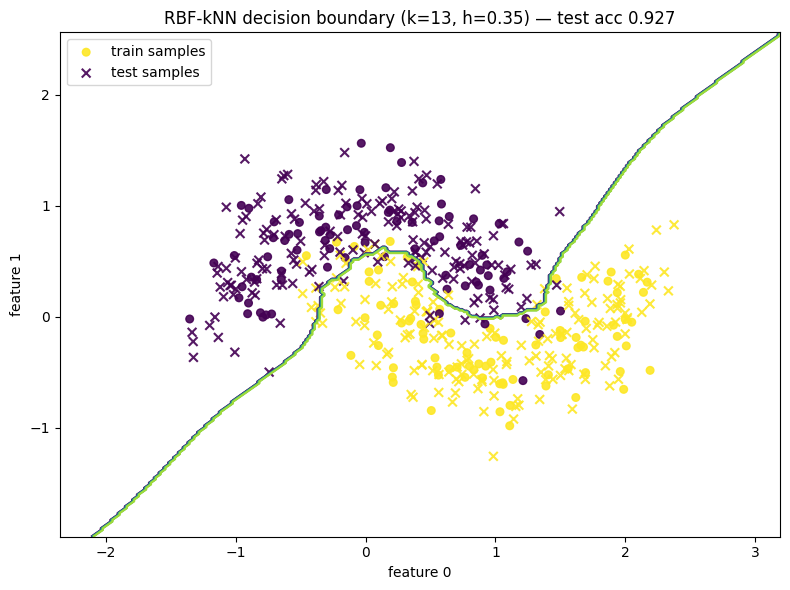

In [67]:
"""
Example: RBF-weighted k-NN on the Moons dataset with DecisionBoundaryDisplay.

Requirements
------------
- numpy
- matplotlib
- scikit-learn
"""

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.inspection import DecisionBoundaryDisplay

# --- Configuration ---
k = None         # number of neighbors - use default sqrt(n_samples)
h = None         # RBF radius (std. dev.) - use default based on training set
random_state = 0
n_samples = 500
noise = 0.25

# --- Prepare data ---
X, y = make_moons(n_samples=n_samples, noise=noise, random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.66, stratify=y, random_state=random_state
)

# --- Build pipeline: scaling + classifier ---
clf = RBFKNeighborsClassifier(k=k, h=h)  # use your implementation
pipe = make_pipeline(StandardScaler(), clf)

# --- Fit and evaluate ---
pipe.fit(X_train, y_train)
acc = pipe.score(X_test, y_test)
print(f"Test accuracy: {acc:.4f}  (k={pipe.named_steps['rbfkneighborsclassifier'].k}, h={pipe.named_steps['rbfkneighborsclassifier'].h})")

# --- Decision boundary visualization ---
fig, ax = plt.subplots(figsize=(8, 6))

# DecisionBoundaryDisplay will plot the decision function (here we use predict)
# The 'from_estimator' helper handles creating the mesh and plotting contours.
DecisionBoundaryDisplay.from_estimator(
    pipe,
    X_train,                # bounds are derived from these points
    response_method="predict",
    plot_method="contour",
    ax=ax, #type: ignore
    grid_resolution=300,
    
)

# Overlay training points (color-coded by class)
ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, label="train samples", alpha=0.9)
ax.scatter(X_test[:, 0], X_test[:, 1], c=y_test, marker='x', s=40, label="test samples", alpha=0.9)

ax.set_title(f"RBF-kNN decision boundary (k={pipe.named_steps['rbfkneighborsclassifier'].k}, h={pipe.named_steps['rbfkneighborsclassifier'].h:.2f}) — test acc {acc:.3f}")
ax.set_xlabel("feature 0")
ax.set_ylabel("feature 1")
ax.legend(loc="upper left")
plt.tight_layout()
plt.show()


In [68]:
def gabriel_graph(X):
    """
    Compute the Gabriel graph matrix for a set of points.
    
    Parameters
    ----------
    X : array-like of shape (n_samples, n_features)
        Input points
        
    Returns
    -------
    adjacency_matrix : ndarray of shape (n_samples, n_samples)
        Binary adjacency matrix where 1 indicates an edge and 0 indicates no edge
    """
    X = np.asarray(X)
    n_points = X.shape[0]
    adjacency_matrix = np.zeros((n_points, n_points), dtype=int)
    
    for i in range(n_points):
        for j in range(i + 1, n_points):
            # Midpoint of edge (i, j)
            midpoint = (X[i] + X[j]) / 2
            # Radius of the circle (half the distance between i and j)
            radius = np.linalg.norm(X[i] - X[j]) / 2
            
            # Check if any other point lies inside the circle
            is_gabriel_edge = True
            for k in range(n_points):
                if k != i and k != j:
                    dist_to_midpoint = np.linalg.norm(X[k] - midpoint)
                    if dist_to_midpoint < radius:
                        is_gabriel_edge = False
                        break
            
            if is_gabriel_edge:
                adjacency_matrix[i, j] = 1
                adjacency_matrix[j, i] = 1
    
    return adjacency_matrix

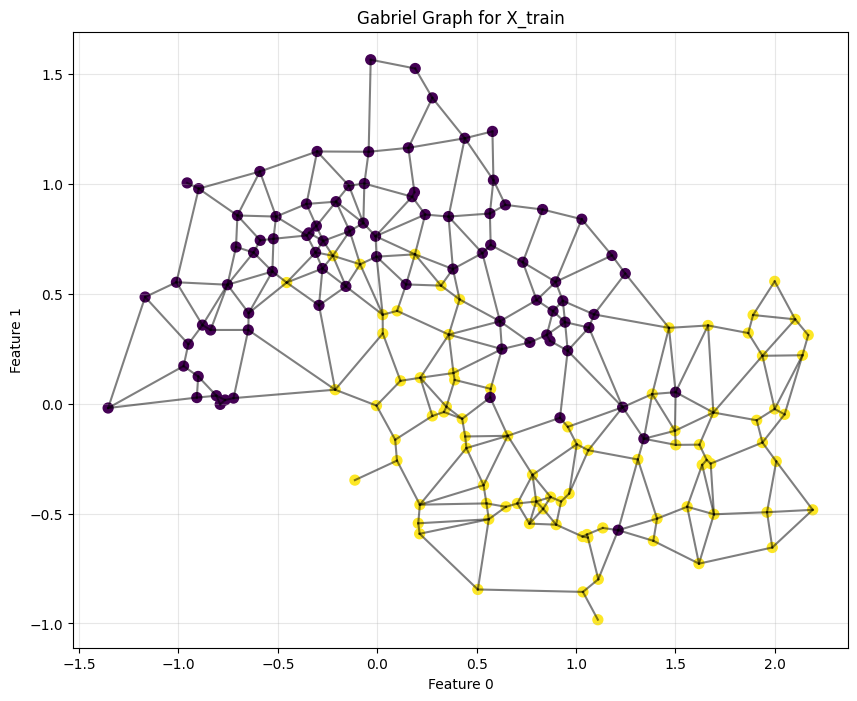

Number of points: 170
Number of Gabriel graph edges: 324
Maximum possible edges: 14365


In [69]:
# Compute Gabriel graph for X_train
gabriel_adj = gabriel_graph(X_train)

# Create visualization
plt.figure(figsize=(10, 8))

# Plot the points colored by class
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=50, label='Points', cmap='viridis')

# Draw edges for Gabriel graph
n_points = X_train.shape[0]
for i in range(n_points):
    for j in range(i + 1, n_points):
        if gabriel_adj[i, j] == 1:
            plt.plot([X_train[i, 0], X_train[j, 0]], 
                    [X_train[i, 1], X_train[j, 1]],
                    'k', alpha=0.5)

plt.title('Gabriel Graph for X_train')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.grid(True, alpha=0.3)
plt.show()

# Print some statistics
n_edges = np.sum(gabriel_adj) // 2  # divide by 2 since matrix is symmetric
print(f"Number of points: {n_points}")
print(f"Number of Gabriel graph edges: {n_edges}")
print(f"Maximum possible edges: {n_points * (n_points - 1) // 2}")

In [70]:
def support_vectors(gabriel_adj, y):
    """
    Return an adjacency matrix indicating Gabriel edges between points of different classes.
    
    Parameters
    ----------
    gabriel_adj : array-like of shape (n_samples, n_samples)
        Binary adjacency matrix of Gabriel graph
    y : array-like of shape (n_samples,)
        Class labels for each sample
        
    Returns
    -------
    differentsupport_vectors_class_matrix : ndarray of shape (n_samples, n_samples)
        Binary matrix where 1 indicates a Gabriel edge between points of different classes
    """
    gabriel_adj = np.asarray(gabriel_adj)
    y = np.asarray(y)
    n_samples = gabriel_adj.shape[0]
    
    # Create matrix indicating different classes
    different_classes = (y[:, np.newaxis] != y[np.newaxis, :]).astype(int)
    
    # Element-wise multiplication: 1 only if Gabriel edge AND different classes
    different_class_matrix = gabriel_adj * different_classes
    
    return different_class_matrix

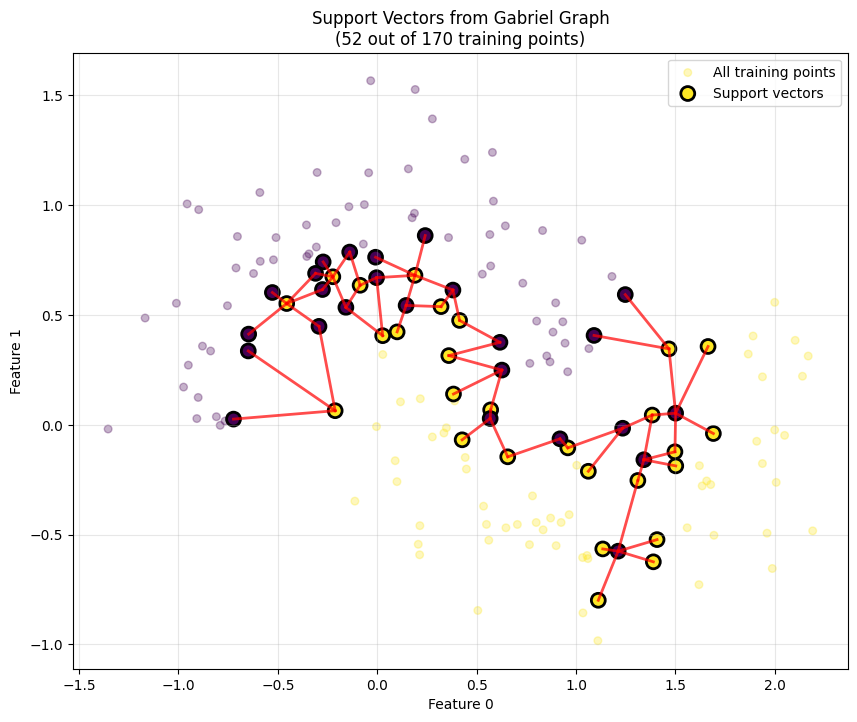

Number of support vectors: 52
Support vector indices: [  1   2   3  20  21  22  26  29  30  40  41  42  46  49  54  57  61  62
  66  77  82  83  84  93  95 101 102 104 105 106 108 113 114 116 123 125
 128 130 137 138 139 144 147 148 150 153 156 158 159 162 165 168]


In [71]:
# Get the support vectors adjacency matrix
support_vectors_adj = support_vectors(gabriel_adj, y_train)

# Find indices of points that are support vectors (connected to points of different classes)
support_vector_indices = np.where(np.sum(support_vectors_adj, axis=1) > 0)[0]

# Create visualization
plt.figure(figsize=(10, 8))

# Plot all training points with light colors
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, s=30, alpha=0.3, cmap='viridis', label='All training points')

# Highlight support vectors with larger, darker markers
plt.scatter(X_train[support_vector_indices, 0], X_train[support_vector_indices, 1], 
           c=y_train[support_vector_indices], s=100, alpha=1.0, cmap='viridis', 
           edgecolors='black', linewidth=2, label='Support vectors')

# Draw edges between support vectors (Gabriel edges between different classes)
for i in range(len(X_train)):
    for j in range(i + 1, len(X_train)):
        if support_vectors_adj[i, j] == 1:
            plt.plot([X_train[i, 0], X_train[j, 0]], 
                    [X_train[i, 1], X_train[j, 1]],
                    'red', alpha=0.7, linewidth=2)

plt.title(f'Support Vectors from Gabriel Graph\n({len(support_vector_indices)} out of {len(X_train)} training points)')
plt.xlabel('Feature 0')
plt.ylabel('Feature 1')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

print(f"Number of support vectors: {len(support_vector_indices)}")
print(f"Support vector indices: {support_vector_indices}")